In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
num_epochs = 6
batch_size = 24
learning_rate = 0.005
num_workers = 12

Getting the CIFAR-10 dataset

In [3]:
def data_loader(transform,
                batch_size=batch_size,
                data_dir="./data",
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    if test:
        dataset = torchvision.datasets.CIFAR10(
          root=data_dir, train=False,
          download=True, transform=transform,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # load the dataset
    train_dataset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    valid_dataset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size,
        sampler=train_sampler, num_workers=num_workers)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size,
        sampler=valid_sampler, num_workers=num_workers)

    return (train_loader, valid_loader)

# # CIFAR10 dataset 
# trainloader, validloader = data_loader(data_dir='./data',
#                                          batch_size=batch_size)

# testloader = data_loader(data_dir='./data',
#                               batch_size=batch_size,
#                               test=True)

classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_classes = len(classes)

In [4]:
base_models = [
    "ResNet34",
    "DENSENET121",
    "SHUFFLENET_V2_X1_0",
    "GOOGLENET",
]
transformations = {
    "ResNet34" : torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms(),
    "DENSENET121": torchvision.models.DenseNet121_Weights.IMAGENET1K_V1.transforms(),
    "SHUFFLENET_V2_X1_0": torchvision.models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1.transforms(),
    "GOOGLENET" : torchvision.models.GoogLeNet_Weights.IMAGENET1K_V1.transforms(),
}

def get_model_variation(name: str, var: int) -> nn.Module:
    new_model = torchvision.models.get_model(name, weights="DEFAULT")
    print(f"Model {name}:", new_model)
    # Freeze training for all layers
    for param in new_model.parameters():
        param.require_grad = False

    # try:
    #     new_model.fc
    # except(AttributeError):
    #     return
    if name.startswith("DENSENET"):
        for param in new_model.parameters():
            param.requires_grad = False
        if var % 2 == 0:
            new_model.classifier = nn.Linear(new_model.classifier.in_features, 10)
            nn.init.xavier_uniform_(new_model.classifier.weight)
        else:
            input_layers = new_model.classifier.in_features
            new_model.classifier = nn.Sequential(
                nn.Linear(input_layers, input_layers//2),
                nn.ReLU(),
                nn.Linear(input_layers//2, 10),
            )
            for param in new_model.classifier.parameters():
                try:
                    nn.init.xavier_normal_(param)
                except(Exception):
                    pass
    else:
        if var % 2 == 0:
            new_model.fc = nn.Linear(new_model.fc.in_features, 10)
            nn.init.xavier_uniform_(new_model.fc.weight)
        else:
            input_layers = new_model.fc.in_features
            new_model.fc = nn.Sequential(
                nn.Linear(input_layers, input_layers//2),
                nn.ReLU(),
                nn.Linear(input_layers//2, 10),
            )
            for param in new_model.fc.parameters():
                try:
                    nn.init.xavier_normal_(param)
                except(Exception):
                    pass
    print(f"Model {name} return:", new_model)
    return new_model


In [5]:
all_models = []
for model_name in base_models:
    all_models.append(get_model_variation(model_name, 0))
    all_models.append(get_model_variation(model_name, 1))
    print(model_name)

Model ResNet34: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

In [7]:
all_loaders = []
for model_name in base_models:
    all_loaders.append(data_loader(transform=transformations[model_name]))
    all_loaders.append(data_loader(transform=transformations[model_name]))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
@torch.no_grad()
def get_accuracy(model, data_loader, device):
    tp = 0
    n = 0
    # model.eval()
    for images, labels in data_loader:
        labels = labels.to(device)
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        n += labels.size(0)
        tp += (predicted == labels).sum()
    return tp / n

@torch.no_grad()
def get_loss(model, data_loader, device, loss_function):
    loss = 0
    n = 0
    # model.eval()
    for images, labels in data_loader:
        labels = labels.to(device)
        images = images.to(device)
        outputs = model(images)
        loss += loss_function(outputs, labels)
        n += labels.size(0)
    return loss / n

def accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))


In [9]:
import time

In [10]:
def train(model, data_loader, test_data_loader, num_epochs, loss_function, optimizer, device):
    train_acc, test_acc = [], []
    start_time = time.time()
    for epoch in range(1, num_epochs+1):
    # model.train(True)
        start_epoch = time.time()
        accuracies = []
        losses = []
        for _, (images, labels) in enumerate(data_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = loss_function(outputs, labels)
            acc = accuracy(outputs, labels)

            losses.append(loss)
            accuracies.append(acc)

            loss.backward()
            optimizer.step()
        curr_train_acc = torch.stack(accuracies).mean()
        train_acc.append(curr_train_acc)
        test_acc.append(get_accuracy(model, test_data_loader, device).cpu())
        print(f"Epoch ({epoch}): Loss = {torch.stack(losses).mean():.4f}, Train accuracy = {curr_train_acc:.4f}, Time of epoch = {time.time() - start_epoch:.4f}")
    print(f'Total time {time.time() - start_time}')
    return (train_acc, test_acc)


In [11]:
import matplotlib.pyplot as plt

def plot_history(history, model_name, num_epochs):
    train_acc, test_acc = history
    x = list(range(1, num_epochs+1))
    plt.figure(figsize=(8,5))
    plt.plot(x, train_acc, label='train')
    plt.plot(x, test_acc, label='test')
    plt.title(f'{model_name}: Accuracy by epoch')
    plt.legend()
    plt.savefig(model_name)
    plt.close()


In [12]:
import typing as tp

results: dict[str, tp.Any] = {'My VGG': 0.7566}

In [14]:
%%time
for index, model in enumerate(all_models):
    print("======================================")
    print(f"Training {index} {model.__class__.__name__} ...")
    model.to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    train_data_loader, test_data_loader = all_loaders[index]
    history = train(model, train_data_loader, test_data_loader, num_epochs, loss_function, optimizer, device)
    curr_loss = get_loss(model, test_data_loader, device, loss_function).cpu()
    curr_accuracy = get_accuracy(model, test_data_loader, device).cpu()
    print(f'Test loss = {curr_loss:.4f}, '+
          f'Test accuracy = {curr_accuracy:.4f}\n')
    results[model.__class__.__name__ + str(index)] = curr_accuracy
    plot_history(history, model.__class__.__name__, num_epochs)
    model.to(torch.device('cpu'))
    torch.cuda.empty_cache()


Training 0 ResNet ...
Epoch (1): Loss = 1.7442, Train accuracy = 0.3674, Time of epoch = 133.3089
Epoch (2): Loss = 1.0186, Train accuracy = 0.6390, Time of epoch = 130.1688
Epoch (3): Loss = 0.7355, Train accuracy = 0.7450, Time of epoch = 130.9413
Epoch (4): Loss = 0.5844, Train accuracy = 0.7985, Time of epoch = 137.7193
Epoch (5): Loss = 0.4678, Train accuracy = 0.8383, Time of epoch = 139.0635
Epoch (6): Loss = 0.3689, Train accuracy = 0.8712, Time of epoch = 148.8398
Total time 820.0424380302429
Test loss = 0.0228, Test accuracy = 0.8182

Training 1 ResNet ...
Epoch (1): Loss = 1.9100, Train accuracy = 0.2695, Time of epoch = 149.3589
Epoch (2): Loss = 1.4619, Train accuracy = 0.4570, Time of epoch = 149.3913
Epoch (3): Loss = 1.0227, Train accuracy = 0.6327, Time of epoch = 152.6595
Epoch (4): Loss = 0.7934, Train accuracy = 0.7193, Time of epoch = 151.8861
Epoch (5): Loss = 0.6333, Train accuracy = 0.7802, Time of epoch = 150.5273
Epoch (6): Loss = 0.5073, Train accuracy = 0.82

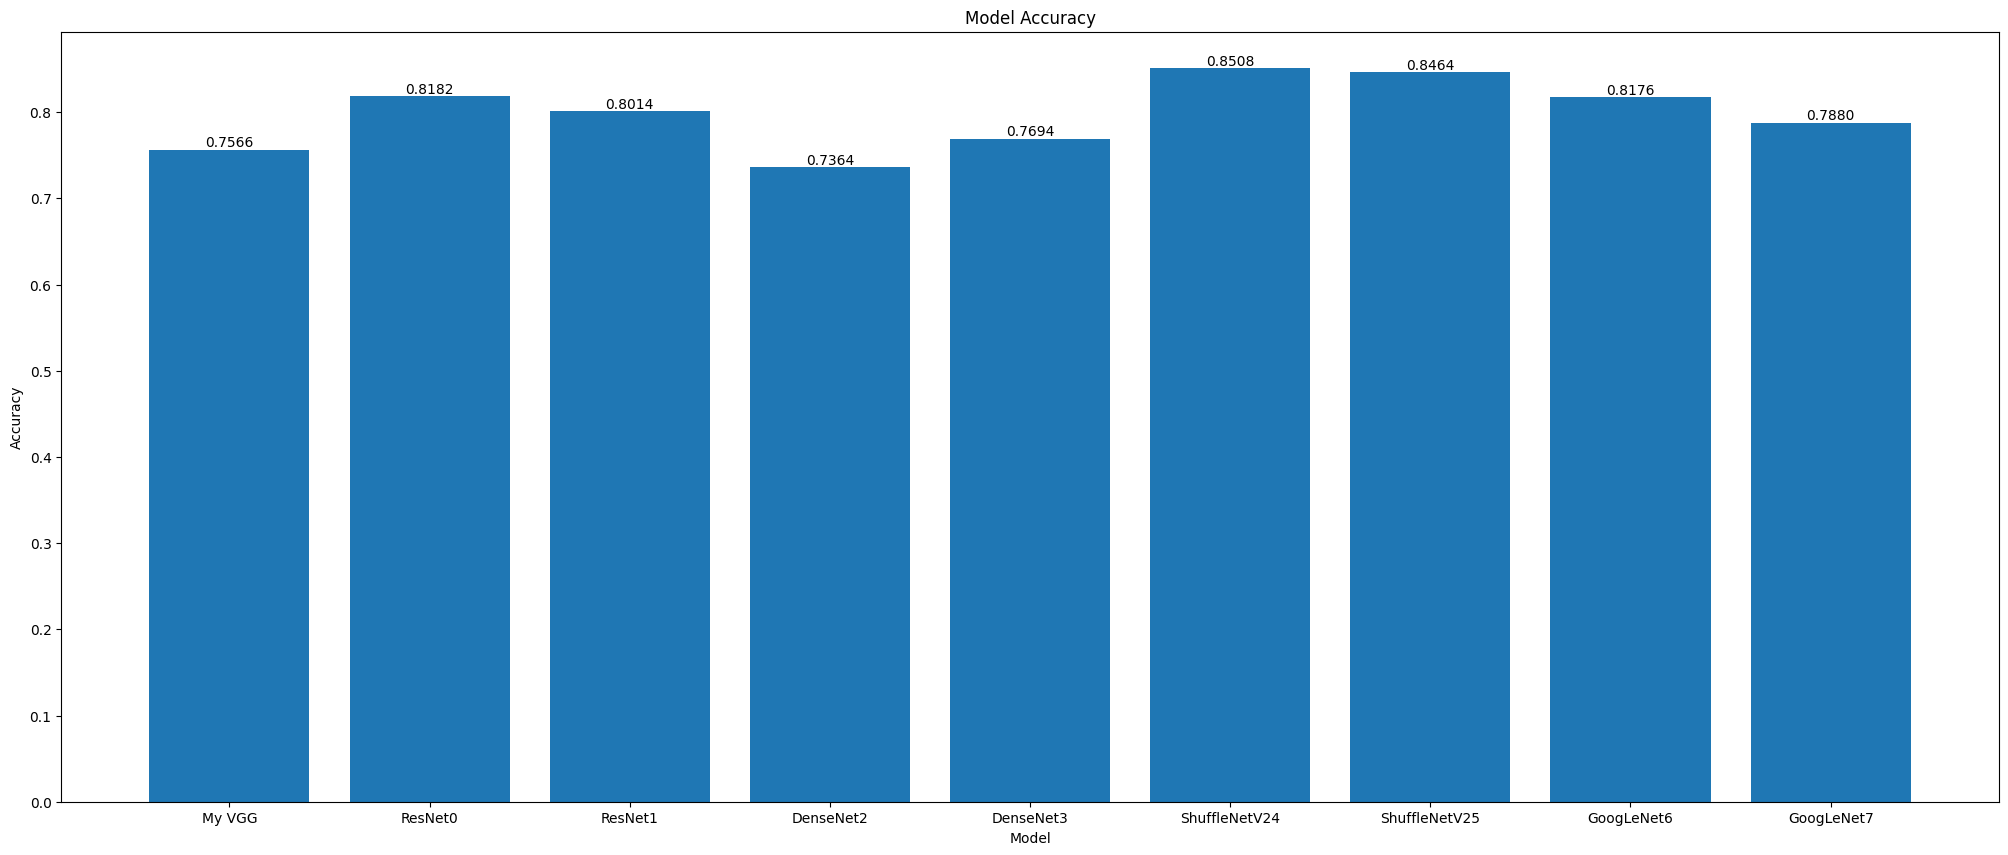

In [15]:
plt.figure(figsize=(25, 10))

plt.bar(results.keys(), results.values())
for i, val in enumerate(results.values()):
    plt.text(i, val, f"{val:.4f}", ha='center', va='bottom')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.show()
